In [0]:
# 統一方法
# df = df[df["state"]!="live"]
# df["state"] = df["state"]=="successful"
# X = df[***].values
# y = df["state"].values
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

初期化処理


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
import seaborn as sns
from pylab import rcParams

### 初期設定
# グラフ描画サイズ設定
rcParams['figure.figsize'] = 6, 6
# 標準化処理オブジェクト
stdsc = StandardScaler()

### 評価用設定
test_size = 0.2         # データ分割
random_state = 1234     # 乱数発生用定数


CSVデータの読み込み

In [0]:
# データの読込み
df_ks = pd.read_csv("./data/kickstarter-projects/ks-projects-201801.csv")

# データ中のシングル、ダブルクォーテーションを削除
df_ks['name'] = df_ks['name'].astype(str).str.replace('"', '').str.replace("'", '')
df_ks['country'] = df_ks['country'].astype(str).str.replace('"', '')

# データ参照
df_ks.head()


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [0]:
# データの要約情報を表示
df_ks.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [0]:
# 欠損値の確認
df_ks.isnull().sum()

ID                     0
name                   0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [0]:
# 欠損値を含む行のの確認
df_ks[df_ks['usd pledged'].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelleys Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETIS 50TH BIRTHDAY FESTIVAL: ORIGINAL...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0",NaN,6695.00,6000.00
870,1004298993,Tamboura Plays Violin - a collection of Pop & ...,Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0",NaN,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,"N,0",NaN,1585.00,1200.00


In [0]:
# 日付データの最大、最小値を確認
print('launched min:{0} max:{1}'.format(df_ks['launched'].min(), df_ks['launched'].max()))
print('deadline min:{0} max:{1}'.format(df_ks['deadline'].min(), df_ks['deadline'].max()))
# df_ks[df_ks['launched'] == '1970-01-01 01:00:00']

launched min:1970-01-01 01:00:00 max:2018-01-02 15:02:31
deadline min:2009-05-03 max:2018-03-03


In [0]:
# launchedの最小値が異常値とかが得られるため、最小値付近のデータを確認
#print(df_ks.sort_values('launched')['launched'])
df_ks.sort_values('launched').head(30)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
75397,1384087152,ICHOR (Canceled),Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,700.00
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,0.00,suspended,0,CH,0.00,0.00,1905.97
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,5000.00
94579,1480763647,Support Solo Theater! Help Ungrateful Daughter...,Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,4000.00
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,10000.00
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,500.00
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,0.00,canceled,0,US,0.00,0.00,15000.00
169268,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,625.00,failed,30,US,625.00,625.00,1000.00
322000,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,22.00,failed,3,US,22.00,22.00,80000.00
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.00,successful,3,US,35.00,35.00,20.00


In [0]:
# launchedの異常値の件数が少ないことから異常データとみなし今回は削除する
df_ks = df_ks[df_ks['launched'] != '1970-01-01 01:00:00']


IDは固有情報のため処理対象外とし削除する

In [0]:
# 処理対象外列を削除
df_ks = df_ks.drop(['ID', 'name'], axis=1)


評価方法を統一用設定

In [0]:
##### データ統一 #####
df_ks = df_ks[df_ks["state"]!="live"]
df_ks["state"] = df_ks["state"]=="successful"
######################

# BOOLデータを数値（0, 1）に変換
df_ks["state"] = df_ks["state"] * 1


In [0]:
def categolical_to_num(df, column_name):
    # 集計値のキー名を取得
    keys = df[column_name].value_counts(normalize = True).keys().tolist()
    # 集計結果を取得
    values = df[column_name].value_counts(normalize = True).tolist()
    # 作成データをDataFrameに変換
    df_worker = pd.DataFrame({column_name : keys, column_name + '_value' : values})
    # データをキー名で結合
    df = pd.merge(df, df_worker, on=column_name)
    # 作成データを返す
    return df

# category
df_ks = categolical_to_num(df_ks, 'category')
# main_category
df_ks = categolical_to_num(df_ks, 'main_category')
# currency
df_ks = categolical_to_num(df_ks, 'currency')
# country
df_ks = categolical_to_num(df_ks, 'country')


In [0]:
# # 分類データを数値に変換
# def categorical_to_num(column_name):
#     target_column = df_ks[column_name]
#     le = preprocessing.LabelEncoder()
#     le.fit(target_column)
#     label_encoded_column = le.transform(target_column)
#     # df_ks[column_name] = pd.Series(label_encoded_column).astype('category')
#     df_ks[column_name + "_p"] = pd.Series(label_encoded_column).astype('int')

# # 変換対象列
# categorical_to_num('category')
# # categorical_to_num('main_category')
# # categorical_to_num('currency')
# # categorical_to_num('country')


説明変数として期間データを作成

In [0]:
# 日付計算
df_ks['date_span'] = (pd.to_datetime(df_ks["deadline"]).dt.date - pd.to_datetime(df_ks["launched"]).dt.date).astype('timedelta64[D]')
# 年月情報を保存
df_ks['launched_y'] = pd.to_datetime(df_ks["launched"]).dt.year
df_ks['launched_m'] = pd.to_datetime(df_ks["launched"]).dt.month

df_ks['deadline_y'] = pd.to_datetime(df_ks["deadline"]).dt.year
df_ks['deadline_m'] = pd.to_datetime(df_ks["deadline"]).dt.month
# 処理済み列を削除
df_ks = df_ks.drop(['launched', 'deadline'], axis=1)


In [0]:
# データ参照
df_ks.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,category_value,main_category_value,currency_value,country_value,date_span,launched_y,launched_m,deadline_y,deadline_m
0,Poetry,Publishing,GBP,1000.0,0.00,0,0,GB,0.00,0.00,1533.95,0.003624,0.105291,0.090069,0.088845,59.0,2015,8,2015,10
1,Poetry,Publishing,GBP,4000.0,20.00,0,1,GB,30.66,30.30,6060.97,0.003624,0.105291,0.090069,0.088845,30.0,2013,6,2013,7
2,Poetry,Publishing,GBP,13.0,125.49,1,17,GB,191.26,192.95,19.99,0.003624,0.105291,0.090069,0.088845,6.0,2015,2,2015,2
3,Poetry,Publishing,GBP,175.0,0.00,0,0,GB,0.00,0.00,268.62,0.003624,0.105291,0.090069,0.088845,13.0,2013,4,2013,4
4,Poetry,Publishing,GBP,2000.0,85.00,0,1,GB,130.51,131.27,3088.61,0.003624,0.105291,0.090069,0.088845,30.0,2015,9,2015,10


In [0]:
# データ参照
df_ks.describe()

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,category_value,main_category_value,currency_value,country_value,date_span,launched_y,launched_m,deadline_y,deadline_m
count,3.758550e+05,3.758550e+05,375855.000000,375855.000000,3.720590e+05,3.758550e+05,3.758550e+05,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000
mean,4.887546e+04,9.687611e+03,0.356403,105.898839,7.080348e+03,9.082847e+03,4.532795e+04,0.019883,0.097156,0.622524,0.609296,34.161677,2014.227838,6.425505,2014.293390,6.761929
std,1.176606e+06,9.588738e+04,0.478937,909.960752,7.893179e+04,9.127160e+04,1.145876e+06,0.015642,0.044766,0.300176,0.305073,12.781798,1.915768,3.310168,1.905109,3.320284
min,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000035,0.009977,0.000082,0.000082,1.000000,2009.000000,1.000000,2009.000000,1.000000
25%,2.000000e+03,3.000000e+01,0.000000,2.000000,1.800000e+01,3.100000e+01,2.000000e+03,0.007072,0.064967,0.781200,0.773918,30.000000,2013.000000,4.000000,2013.000000,4.000000
50%,5.100000e+03,6.250000e+02,0.000000,12.000000,4.000000e+02,6.276000e+02,5.480040e+03,0.016671,0.092972,0.781200,0.773918,30.000000,2014.000000,6.000000,2015.000000,7.000000
75%,1.600000e+04,4.090000e+03,1.000000,56.000000,3.057000e+03,4.064960e+03,1.550000e+04,0.030475,0.137383,0.781200,0.773918,37.000000,2016.000000,9.000000,2016.000000,10.000000
max,1.000000e+08,2.033899e+07,1.000000,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,0.058738,0.168286,0.781200,0.773918,92.000000,2018.000000,12.000000,2018.000000,12.000000


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


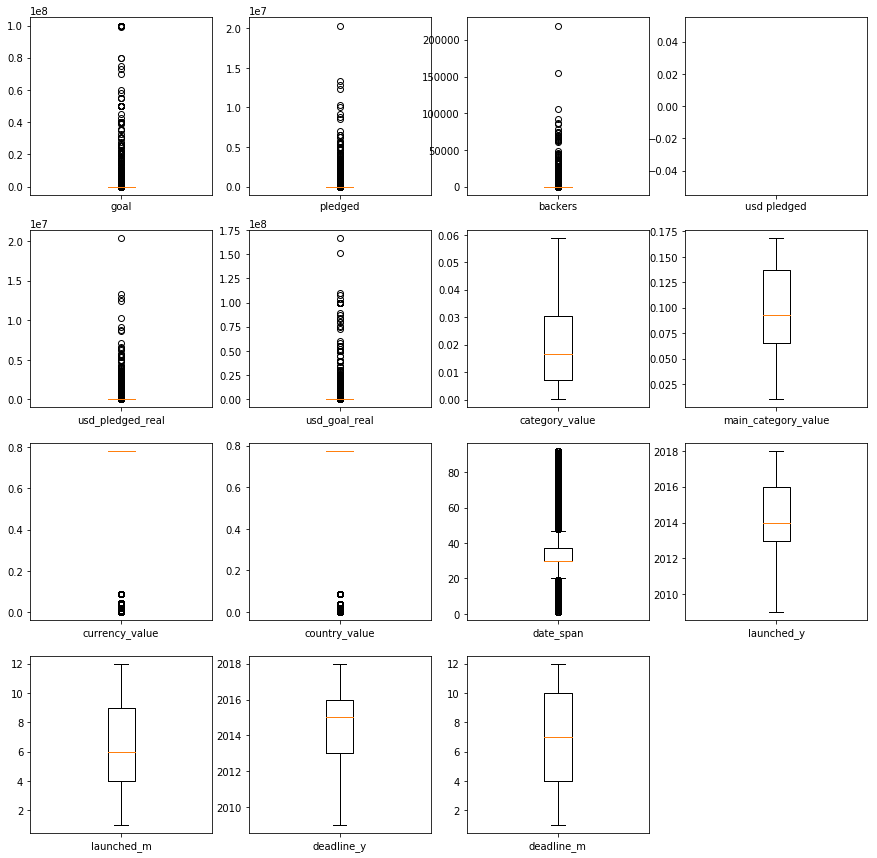

In [0]:
# 箱ひげ図
targets = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'category_value', 'main_category_value', 'currency_value', 'country_value', 'date_span', 'launched_y', 'launched_m', 'deadline_y', 'deadline_m']
fig = plt.figure(figsize=(15,15))
for idx in range(len(targets)):
    ax = fig.add_subplot(4, 4, idx + 1)
    ax.boxplot(df_ks[targets[idx]], labels = [targets[idx]])

In [0]:
# データの開きが大きいための対数をとる
df_ks['goal'] = np.log1p(df_ks['goal'])
df_ks['pledged'] = np.log1p(df_ks['pledged'])
df_ks['backers'] = np.log1p(df_ks['backers'])
df_ks['usd pledged'] = np.log1p(df_ks['usd pledged'])
df_ks['usd_pledged_real'] = np.log1p(df_ks['usd_pledged_real'])
df_ks['usd_goal_real'] = np.log1p(df_ks['usd_goal_real'])
df_ks['currency_value'] = np.log1p(df_ks['currency_value'])
df_ks['country_value'] = np.log1p(df_ks['country_value'])
df_ks['date_span'] = np.log1p(df_ks['date_span'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


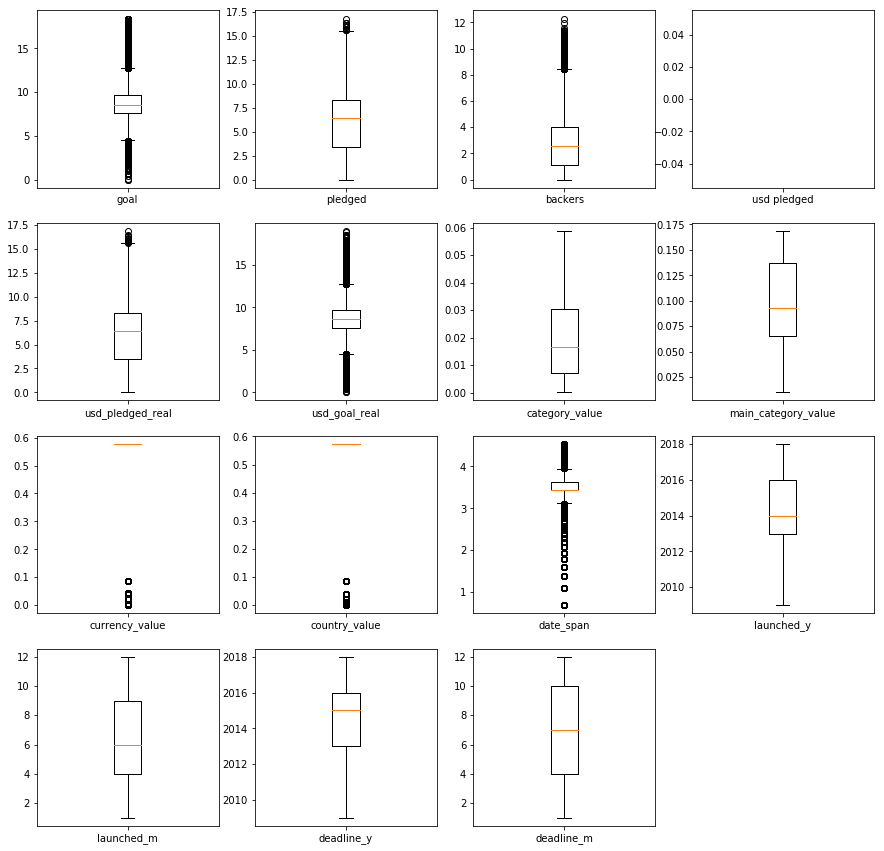

In [0]:
# 箱ひげ図
targets = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'category_value', 'main_category_value', 'currency_value', 'country_value', 'date_span', 'launched_y', 'launched_m', 'deadline_y', 'deadline_m']
fig = plt.figure(figsize=(15,15))
for idx in range(len(targets)):
    ax = fig.add_subplot(4, 4, idx + 1)
    ax.boxplot(df_ks[targets[idx]], labels = [targets[idx]])

kickstarter開始時の未確定データ列の削除


*   backers：終了時に確定される支援者数
*   pledged：終了時に確定される集金額
*   goal：目標金額（目標金額のUSD返還後列を使用するため削除）

In [0]:
# 列の削除

# 未確定変数を削除
df_ks = df_ks.drop(['goal', 'pledged', 'backers', 'usd pledged'], axis=1)

# 分類用文字列編集を削除
df_ks = df_ks.drop(['category', 'main_category', 'currency', 'country'], axis=1)


In [0]:
df_ks.head()


,state,usd_pledged_real,usd_goal_real,category_value,main_category_value,currency_value,country_value,date_span,launched_y,launched_m,deadline_y,deadline_m
0,0,0.000000,7.336253,0.003624,0.105291,0.086241,0.085118,4.094345,2015,8,2015,10
1,0,3.443618,8.709790,0.003624,0.105291,0.086241,0.085118,3.433987,2013,6,2013,7
2,1,5.267600,3.044046,0.003624,0.105291,0.086241,0.085118,1.945910,2015,2,2015,2
3,0,0.000000,5.597014,0.003624,0.105291,0.086241,0.085118,2.639057,2013,4,2013,4
4,0,4.884845,8.035800,0.003624,0.105291,0.086241,0.085118,3.433987,2015,9,2015,10


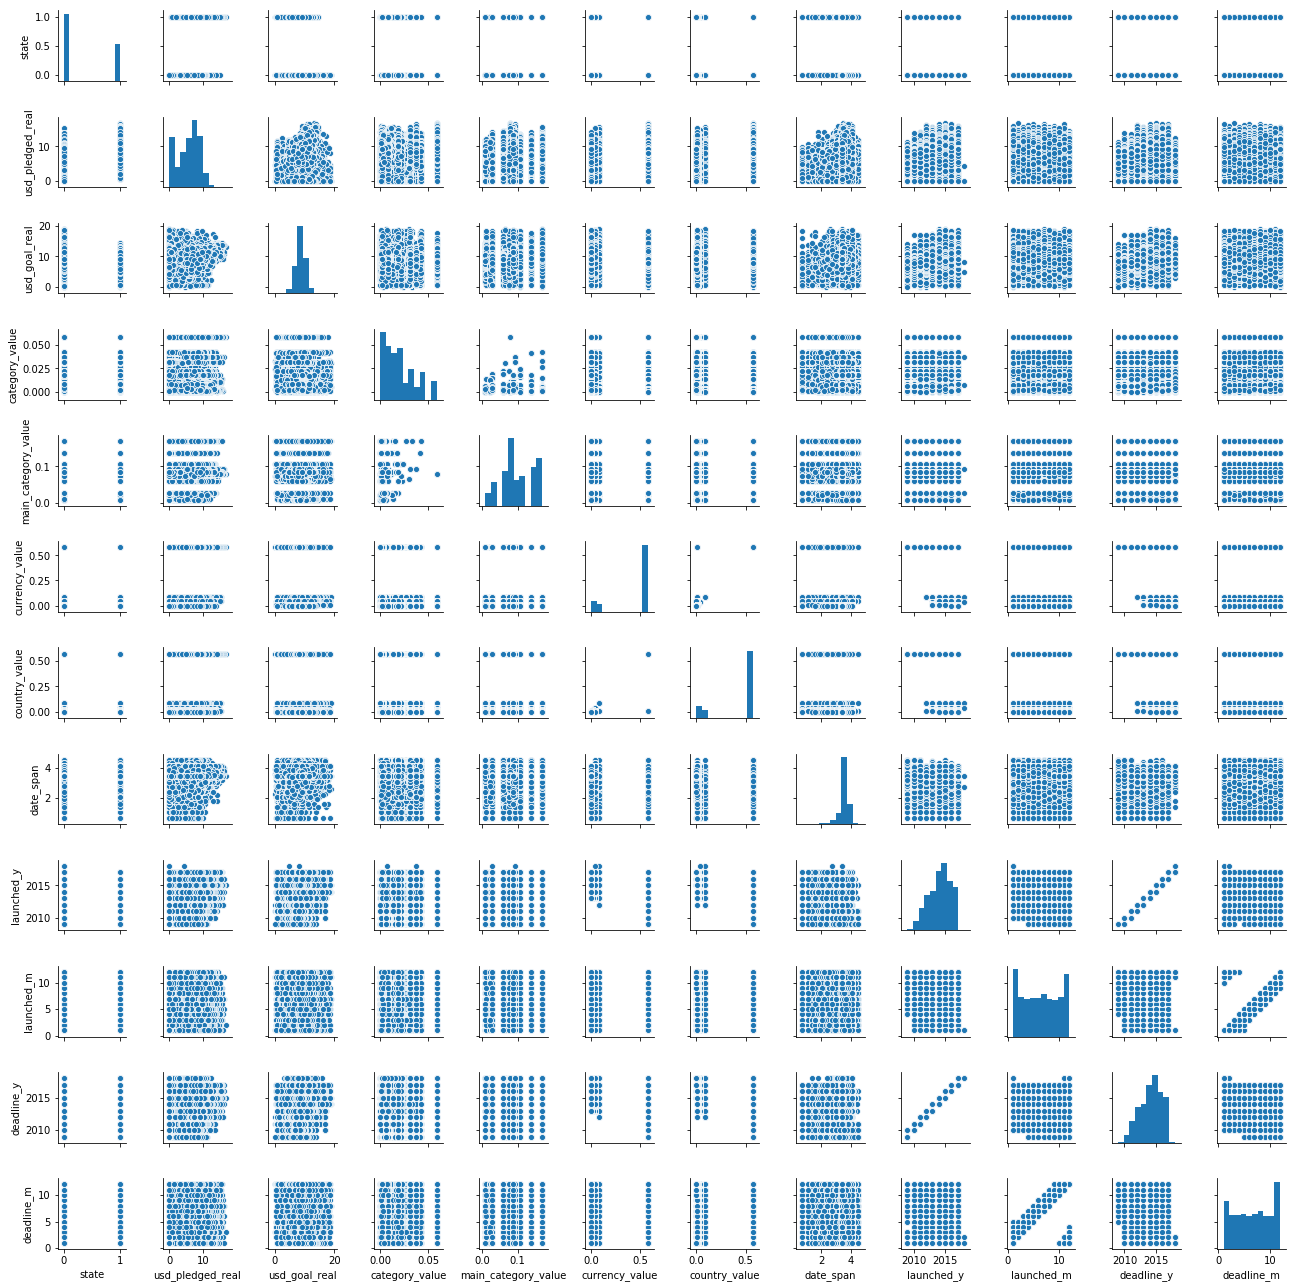

In [0]:
# 散布図行列を出力
# pd.plotting.scatter_matrix(df_ks[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'date_span', 'launched_y', 'launched_m', 'deadline_y', 'deadline_m', 'state']], figsize=(10, 10))
# pd.plotting.scatter_matrix(df_ks, figsize=(10, 10))
# plt.show()
# sns.pairplot(df_ks[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'date_span', 'launched_y', 'launched_m', 'deadline_y', 'deadline_m', 'state']], )
sns.pairplot(df_ks, height=1.5, aspect=1.0)

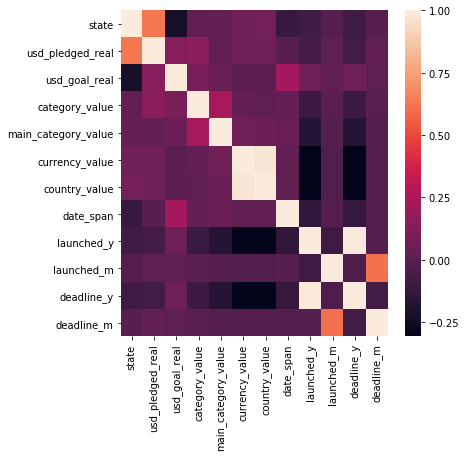

In [0]:
# # 説明変数の相関係数を確認
# df_ks.corr()
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks.corr())
plt.show()


In [0]:
df_ks.head()

,state,usd_pledged_real,usd_goal_real,category_value,main_category_value,currency_value,country_value,date_span,launched_y,launched_m,deadline_y,deadline_m
0,0,0.000000,7.336253,0.003624,0.105291,0.086241,0.085118,4.094345,2015,8,2015,10
1,0,3.443618,8.709790,0.003624,0.105291,0.086241,0.085118,3.433987,2013,6,2013,7
2,1,5.267600,3.044046,0.003624,0.105291,0.086241,0.085118,1.945910,2015,2,2015,2
3,0,0.000000,5.597014,0.003624,0.105291,0.086241,0.085118,2.639057,2013,4,2013,4
4,0,4.884845,8.035800,0.003624,0.105291,0.086241,0.085118,3.433987,2015,9,2015,10


In [0]:
# 無相関化
def decorreelation(column_name1, column_name2):
    data = df_ks[[column_name1, column_name2]]
    # 分散・共分散を求める
    cov = np.cov(data, rowvar=0)
    # 分散共分散行列の固有ベクトルを用いて
    _, S = np.linalg.eig(cov)
    # データを無相関化
    decorr = np.dot(S.T, data.T).T
    # データを更新
    df_ks[column_name1] = decorr[:, 0]
    df_ks[column_name2] = decorr[:, 1]

# 無相関化
# decorreelation('currency', 'country')
decorreelation('launched_y', 'deadline_y')
decorreelation('launched_m', 'deadline_m')


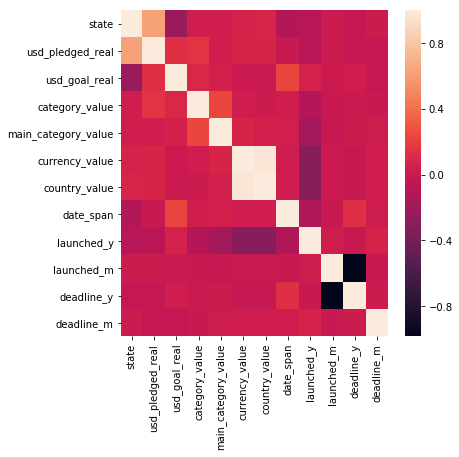

In [0]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks.corr())
plt.show()


各種数値データの単位が揃っていないため標準化を実施する


In [0]:
def standardizationColumn(df_worker, columnName):
    # # 標準化
    # data = stdsc.fit_transform(df_worker[[columnName]].values)
    # # 標準化済みデータを新規列としてデータフレームに追加
    # df_worker['{0}_std'.format(columnName)] = data
    # # 処理済み列を削除
    # df_worker = df_worker.drop(columnName, axis=1, inplace=True)
    # 標準化
    df_worker[[columnName]] = stdsc.fit_transform(df_worker[[columnName]].values)

# 各数値データを標準化
# goal
# standardizationColumn(df_ks, 'goal')
# pledged
# standardizationColumn(df_ks, 'pledged')
# backers
# standardizationColumn(df_ks, 'backers')
# usd pledged
# standardizationColumn(df_ks, 'usd pledged')
# usd_pledged_real
standardizationColumn(df_ks, 'usd_pledged_real')
# usd_goal_real
standardizationColumn(df_ks, 'usd_goal_real')
# delta(日付情報)
standardizationColumn(df_ks, 'date_span')
standardizationColumn(df_ks, 'launched_y')
standardizationColumn(df_ks, 'launched_m')
standardizationColumn(df_ks, 'deadline_y')
standardizationColumn(df_ks, 'deadline_m')
standardizationColumn(df_ks, 'country_value')
standardizationColumn(df_ks, 'category_value')
standardizationColumn(df_ks, 'main_category_value')

# 要約情報を表示
df_ks.describe()

,state,usd_pledged_real,usd_goal_real,category_value,main_category_value,currency_value,country_value,date_span,launched_y,launched_m,deadline_y,deadline_m
count,375855.000000,3.758550e+05,3.758550e+05,3.758550e+05,3.758550e+05,375855.000000,3.758550e+05,3.758550e+05,3.758550e+05,3.758550e+05,3.758550e+05,3.758550e+05
mean,0.356403,2.016167e-14,3.834680e-15,-4.744608e-14,-5.185555e-13,0.462802,-3.844336e-13,3.095844e-14,-3.270378e-13,8.215043e-15,7.578666e-15,1.537462e-14
std,0.478937,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.216761,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-1.735701e+00,-5.101097e+00,-1.268958e+00,-1.947421e+00,0.000082,-2.043618e+00,-7.540336e+00,-2.759334e+00,-3.862305e+00,-3.848153e-01,-1.818476e+00
25%,0.000000,-6.908753e-01,-6.119533e-01,-8.190555e-01,-7.190501e-01,0.577287,5.389894e-01,-1.653165e-01,-6.611891e-01,2.194103e-01,-2.937924e-01,-8.101508e-01
50%,0.000000,2.068383e-01,-1.608890e-02,-2.053505e-01,-9.345336e-02,0.577287,5.389894e-01,-1.653165e-01,1.248772e-01,2.262488e-01,-2.482809e-01,3.124542e-02
75%,1.000000,7.696610e-01,5.986758e-01,6.771056e-01,8.986102e-01,0.577287,5.389894e-01,3.825251e-01,9.124193e-01,2.330872e-01,-2.255251e-01,7.040248e-01
max,1.000000,3.337500e+00,6.086928e+00,2.484031e+00,1.588930e+00,0.577287,5.389894e-01,2.790816e+00,1.961492e+00,1.254371e+00,3.852828e+00,1.881811e+00


相関データを確認する

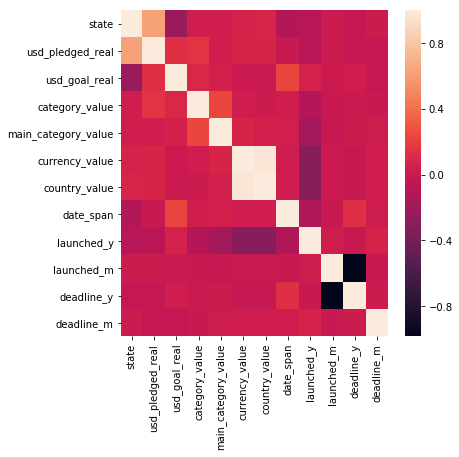

In [0]:
# 数値データのヒートマップを出力
sns.heatmap(df_ks.corr())

データの編集処理を実施


*   kickstarter実施期間列を追加
*   文字列データに対してダミデータを作成
*   編集処理後の不要な列を削除



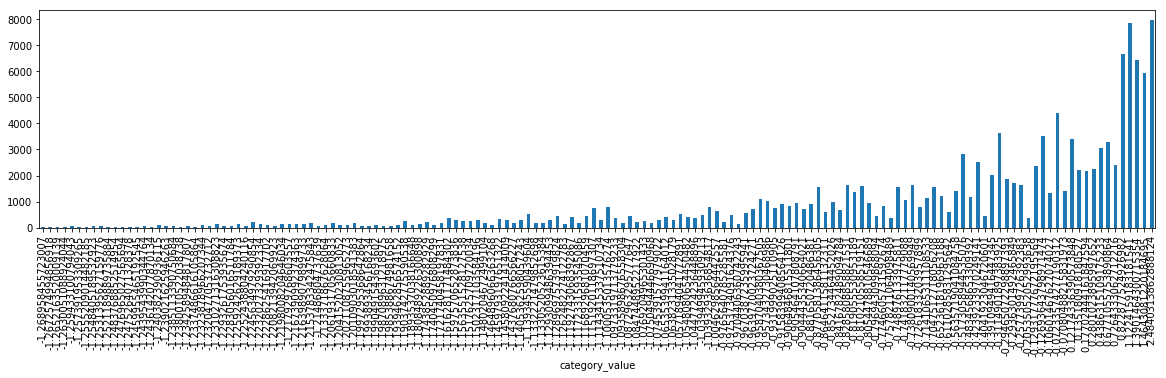

In [0]:
# カテゴリー別成功データ件数
df_worker = df_ks.groupby(['category_value'])['state'].sum()
# グラフ表示
df_worker.plot.bar(figsize=(20, 4))

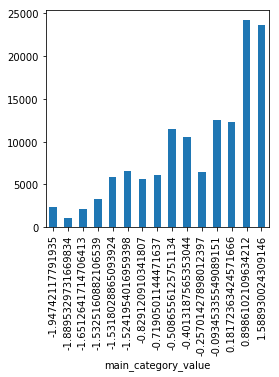

In [0]:
# カテゴリー別成功データ件数
df_worker = df_ks.groupby(['main_category_value'])['state'].sum()
# グラフ表示
df_worker.plot.bar(figsize=(4, 4))

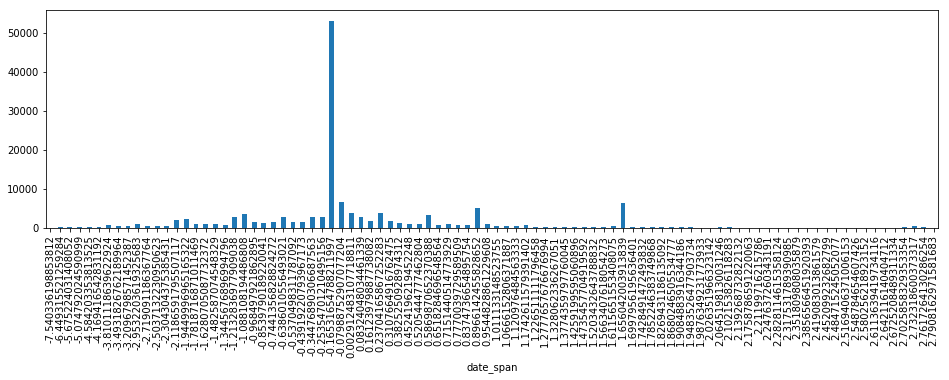

In [0]:
# 実施日数別成功データ件数
df_worker = df_ks.groupby(['date_span'])['state'].sum()
# グラフ表示
df_worker.plot.bar(figsize=(16, 4))

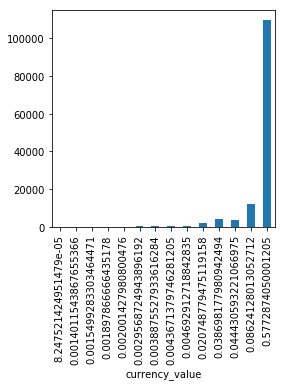

In [0]:
# 通貨別成功データ件数
df_worker = df_ks.groupby(['currency_value'])['state'].sum()
# グラフ表示
df_worker.plot.bar(figsize=(4, 4))

In [0]:
# 欠損値の確認
df_ks.isnull().sum()

state                  0
usd_pledged_real       0
usd_goal_real          0
category_value         0
main_category_value    0
currency_value         0
country_value          0
date_span              0
launched_y             0
launched_m             0
deadline_y             0
deadline_m             0
dtype: int64

In [0]:
# # 欠損値を削除
# df_ks = df_ks.dropna(how='any')
# # データ参照
# df_ks.head()


In [0]:
# # category と main_caegory は同じ意味合いのため削除
# df_ks = df_ks.drop('main_category_value', axis=1)
# # データ参照
# df_ks.head()


特徴選択

Feature ranking: 
[1 1 3 8 1 2 5 4 7 9 6]


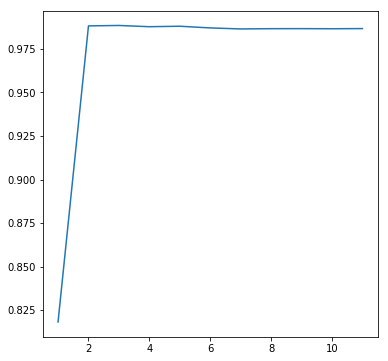

In [0]:
# estimatorにモデルをセット
# estimator = SGDClassifier(loss='log', penalty='l1', max_iter=100, fit_intercept=True, random_state=1234)
estimator = SGDClassifier(loss='log', max_iter=1000, fit_intercept=True, random_state=random_state, alpha = 1e-05)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
rfecv = RFECV(estimator, cv=5, scoring='accuracy')

feat_train_label = df_ks["state"]
feat_train_data = df_ks.drop("state", axis=1)

feat_y = feat_train_label.values
feat_X = feat_train_data.values

# fitで特徴選択を実行
rfecv.fit(feat_X, feat_y)

# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [0]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8,10))

degree = 20
#正則化全体の強さを決定する
alpha = 1e-4
#L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）
l1_ratios = [0, 0.1, 0.5, 1.0]

for l1_ratio, ax_row in zip(l1_ratios, ax_rows):
    ax_left, ax_right = ax_row
    # ConvergenceWarning が出るときがあるが、グラフが表示されていれば実行は出来ているので気にしなくて良い
    est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1e8))
    est.fit(X, y)
    plot_approximation(est, ax_left, label='l1_ratio=%r' % l1_ratio)
    plot_coefficients(est, ax_right, label='ElasticNet(l1_ratio=%r) coefficients' % l1_ratio, yscale=None)

plt.tight_layout()


In [0]:
from sklearn.model_selection import train_test_split

# 目的変数データ
y = df_ks['state'].values
# 説明変数データ
x = df_ks.drop(['state'], axis=1).values
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)


In [0]:
from sklearn.model_selection import GridSearchCV

# データサイズを取得
n = y.shape[0]
# モデルを作成
model = SGDClassifier(loss='log', penalty='elasticnet',max_iter = np.ceil(10**6 / n),shuffle=True)

# param_grid = [{'alpha' : 10.0**-np.arange(1,7),'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]}]
param_grid = [{'alpha' : 10.0**-np.arange(1,7)}]
gs = GridSearchCV(model,param_grid,n_jobs=8,verbose=1)
gs.fit(X_train, y_train)

print("Scores for alphas:")
print(gs.best_score_)
print("Best estimator:")
print(gs.best_estimator_)
print("Best score:")
print(gs.best_score_)
print("Best parameters:")
print(gs.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    5.8s finished


Scores for alphas:
0.9905149592262974
Best estimator:
SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=3.0,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score:
0.9905149592262974
Best parameters:
{'alpha': 1e-05}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [0]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数

# Scikit-learnを用いてロジスティック回帰
# alphaは先に求めた結果を使用する
clf = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000, fit_intercept=True, random_state=random_state, alpha = gs.best_params_['alpha'])
# 正則化設定を追加
# clf = SGDClassifier(loss='log', penalty='elasticnet', max_iter=5, fit_intercept=True, random_state=1234)
# clf = SGDClassifier(loss='hinge', penalty='elasticnet', max_iter=5, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)


SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# 重みを取得して表示(w0)
w0 = clf.intercept_[0]
print("w0:{0}".format(w0))

# 重みを取得して表示(w1-)
for i in range(len(clf.coef_[0])):
    print("w{0} = {1}".format(i, clf.coef_[0, i]))


w0:-15.256023468437048
w0 = 25.747318386146297
w1 = -12.934397894236644
w2 = -0.6840634146157807
w3 = 0.4058449604586804
w4 = -10.546221461830651
w5 = 2.5639509266061125
w6 = -0.23891073583202418
w7 = -0.3336131585857715
w8 = 0.0
w9 = -0.013141653707181879
w10 = 0.10285392780726989


In [0]:
# ラベルを予測
y_est = clf.predict(x)
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y, y_est)))
# 正答率（Accuracy）を表示
print('正答率（Accuracy） = {}%'.format(100 * accuracy_score(y, y_est)))
# 精度（Precision）を表示 
print('精度（Precision） = {}%'.format(100 * precision_score(y, y_est)))
# 検出率 (Recall)を表示
print('検出率 (Recall) = {}%'.format(100 * recall_score(y, y_est)))
# F値を表示
print('F値 = {}%'.format(100 * f1_score(y, y_est)))

対数尤度 = -0.309
正答率（Accuracy） = 99.10603823282915%
精度（Precision） = 97.79534475186648%
検出率 (Recall) = 99.74021320433575%
F値 = 98.75820471882206%


In [0]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train)
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

####### RMSE : 予測と実際の差の二乗の平均の平方根 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE_TEST = %s" % round(rmse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE_TRAIN = %s" % round(rmse_train, 3) )

####### MAE : 予測と実際の差の絶対値の平均 #######

# 学習データに対するMAEを計算（訓練誤差の評価）
mae_test = mean_absolute_error(y_train, y_pred_train)
print("MAE_TEST = %s" % round(mae_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mae_train = mean_absolute_error(y_test, y_pred_test)
print("MAE_TRAIN = %s" % round(mae_train, 3) )

####### MSE : 予測と実際の差の二乗の平均 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
mse_test = mean_squared_error(y_train, y_pred_train)
print("MSE_TEST = %s" % round(mse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mse_train = mean_squared_error(y_test, y_pred_test)
print("MSE_TRAIN = %s" % round(mse_train, 3) )


RMSE_TEST = 0.094
RMSE_TRAIN = 0.095
MAE_TEST = 0.009
MAE_TRAIN = 0.009
MSE_TEST = 0.009
MSE_TRAIN = 0.009


In [0]:
from sklearn.svm import SVC

# SVMの実行
C = 5
clf = SVC(C=C, kernel="linear")
clf.fit(X_train, y_train)


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# 超平面上の値を確認する
# 超平面上で0以上になるとき、y=1と判定される領域にいることになる。
# 超平面上で0未満になるとき、y=-1と判定される領域にいることになる。
np.dot(X_train, clf.coef_.T) + clf.intercept_


array([[ -9.00914149],
       [-37.97623387],
       [-23.43600892],
       ...,
       [-37.28191547],
       [  5.24956176],
       [-17.69148012]])

In [0]:
# ラベルを予測
y_est = clf.predict(x)
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y, y_est)))
# 正答率（Accuracy）を表示
print('正答率（Accuracy） = {}%'.format(100 * accuracy_score(y, y_est)))
# 精度（Precision）を表示 
print('精度（Precision） = {}%'.format(100 * precision_score(y, y_est)))
# 検出率 (Recall)を表示
print('検出率 (Recall) = {}%'.format(100 * recall_score(y, y_est)))
# F値を表示
print('F値 = {}%'.format(100 * f1_score(y, y_est)))

対数尤度 = -0.230
正答率（Accuracy） = 99.33538199571643%
精度（Precision） = 98.22377109317682%
検出率 (Recall) = 99.94251843889039%
F値 = 99.07569119649517%


In [0]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train)
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

####### RMSE : 予測と実際の差の二乗の平均の平方根 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE_TEST = %s" % round(rmse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE_TRAIN = %s" % round(rmse_train, 3) )

####### MAE : 予測と実際の差の絶対値の平均 #######

# 学習データに対するMAEを計算（訓練誤差の評価）
mae_test = mean_absolute_error(y_train, y_pred_train)
print("MAE_TEST = %s" % round(mae_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mae_train = mean_absolute_error(y_test, y_pred_test)
print("MAE_TRAIN = %s" % round(mae_train, 3) )

####### MSE : 予測と実際の差の二乗の平均 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
mse_test = mean_squared_error(y_train, y_pred_train)
print("MSE_TEST = %s" % round(mse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mse_train = mean_squared_error(y_test, y_pred_test)
print("MSE_TRAIN = %s" % round(mse_train, 3) )


RMSE_TEST = 0.081
RMSE_TRAIN = 0.082
MAE_TEST = 0.007
MAE_TRAIN = 0.007
MSE_TEST = 0.007
MSE_TRAIN = 0.007


In [0]:
# # 決定領域を描画する
# plot_decision_regions(X_train, y_train, classifier=clf)
# plt.plot(X_test[:,0],X_test[:,1], color="g", marker="o",ls="")
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()



In [0]:
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 400000

# print('X_train {0}, y_pred_train {1}'.format(X_train.shape, y_pred_train.shape))

# # グラフに重ねて表示する
# plt.plot(X_train, y_train, 'o', label='training data')
# plt.plot(X_test, y_test, '^', label='test data')
# # plt.ylabel("price")
# # plt.xlabel("carat")
# plt.grid(which='major',color='black',linestyle=':')
# plt.grid(which='minor',color='black',linestyle=':')
# plt.plot(X_train, y_pred_train, label='regression')
# plt.legend(loc='best')
# plt.show()


In [0]:
X = x
Y = y
# 分割数を設定
n_split = 5

cross_valid_mae = 0
cross_valid_rsme = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す,
kf = KFold(n_splits=n_split, shuffle=True, random_state=1234)

for train_idx, test_idx in kf.split(X, Y): 
    # 学習用データ
    X_train, y_train = X[train_idx], Y[train_idx]
    #テスト用データ
    X_test, y_test = X[test_idx], Y[test_idx]

    # 正則化設定を追加
    clf = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000, fit_intercept=True, random_state=random_state, alpha = gs.best_params_['alpha'])
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_est = clf.predict(X_test)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_est)
    rsme = np.sqrt(mean_squared_error(y_test, y_est))
    print("Fold {0} // MAE = {1}, RMSE = {2}".format(split_num, round(mae, 3), round(rsme, 3)))

    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(-log_loss(y_test, y_est)))
    # 正答率（Accuracy）を表示
    print('正答率（Accuracy） = {}%'.format(100 * accuracy_score(y_test, y_est)))
    # 精度（Precision）を表示 
    print('精度（Precision） = {}%'.format(100 * precision_score(y_test, y_est)))
    # 検出率 (Recall)を表示
    print('検出率 (Recall) = {}%'.format(100 * recall_score(y_test, y_est)))
    # F値を表示
    print('F値 = {}%'.format(100 * f1_score(y_test, y_est)))
    # 改行用
    print('')

    #後で平均を取るためにMAEを加算
    cross_valid_mae += mae
    cross_valid_rsme += rsme
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
print("Cross Validation MAE = {0}, RSME = {1}".format(round(cross_valid_mae / n_split, 3), round(cross_valid_rsme / n_split, 3)))



Fold 1 // MAE = 0.01, RMSE = 0.098
対数尤度 = -0.331
正答率（Accuracy） = 99.0408535206396%
精度（Precision） = 97.45830602286796%
検出率 (Recall) = 99.91413745473551%
F値 = 98.67094324319343%

Fold 2 // MAE = 0.009, RMSE = 0.096
対数尤度 = -0.318
正答率（Accuracy） = 99.0807625281026%
精度（Precision） = 97.54074398889132%
検出率 (Recall) = 99.93261203249597%
F値 = 98.72219242931375%

Fold 3 // MAE = 0.009, RMSE = 0.095
対数尤度 = -0.315
正答率（Accuracy） = 99.08874432959519%
精度（Precision） = 97.60040414246022%
検出率 (Recall) = 99.9261120141865%
F値 = 98.74956645552291%

Fold 4 // MAE = 0.009, RMSE = 0.094
対数尤度 = -0.306
正答率（Accuracy） = 99.11402003432175%
精度（Precision） = 97.61313868613138%
検出率 (Recall) = 99.95515359892369%
F値 = 98.77026478082648%

Fold 5 // MAE = 0.009, RMSE = 0.096
対数尤度 = -0.318
正答率（Accuracy） = 99.07810192760506%
精度（Precision） = 97.53692775721146%
検出率 (Recall) = 99.92114749173926%
F値 = 98.71464342019846%

Cross Validation MAE = 0.009, RSME = 0.096
